<a href="https://colab.research.google.com/github/honggi82/Software_application_lecture/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 설치

In [1]:
!pip install tensorflow
!pip install opencv-python

# 라이브러리 가져오기

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape, Conv2D, Conv2DTranspose, Dropout, BatchNormalization, LeakyReLU
import numpy as np
import matplotlib.pyplot as plt

# Fashion mnist 데이터셋 불러오기

In [3]:
(train_X, _), (_, _) = fashion_mnist.load_data() # we need only train_X data

# 데이터 정규화

In [4]:
train_X = (train_X.reshape(train_X.shape[0], 28, 28, 1).astype('float32')-127.5) / 127.5

# Data shuffle

In [5]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(train_X).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# DCGAN 생성

In [6]:
codings_size = 30 # size of the input noise

generator = Sequential([
    Dense(7 * 7 * 128, input_shape=[codings_size]),
    Reshape([7, 7, 128]),
    BatchNormalization(),
    Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="relu"),
    BatchNormalization(),
    Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME", activation="tanh")
])
discriminator = Sequential([
    Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=LeakyReLU(0.2),input_shape=[28, 28, 1]),
    BatchNormalization(),
    Dropout(0.4),
    Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Dropout(0.4),
    Flatten(),
    Dense(1, activation="sigmoid")
])
gan = Sequential([generator, discriminator])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
discriminator.compile(loss="binary_crossentropy", optimizer="Adam")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="Adam")

여러 개의 이미지를 그리기 위한 함수 정의

In [8]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# DCGAN을 학습시키는 train_gan 함수 정의

In [9]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in dataset:
            # training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)
        plt.show()

# DCGAN 학습

Epoch 1/10


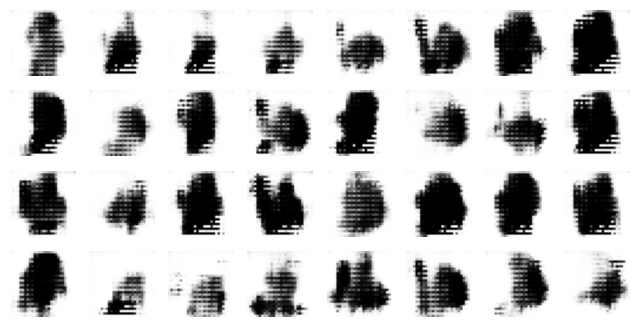

Epoch 2/10


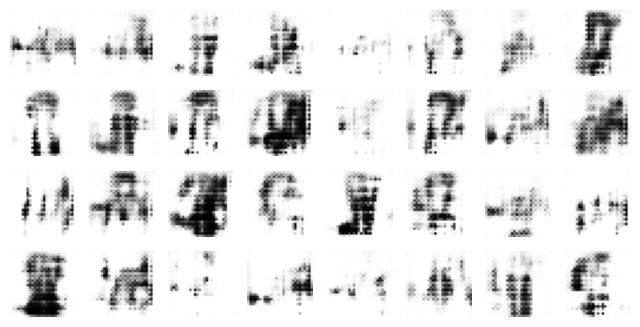

Epoch 3/10


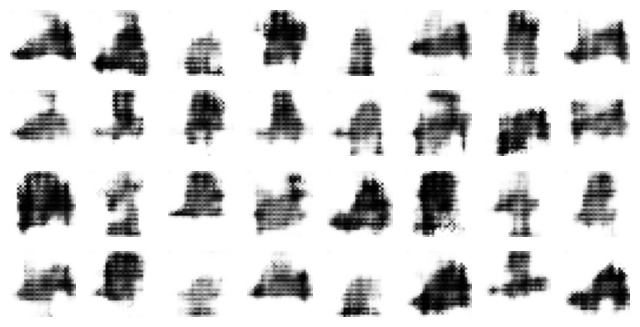

Epoch 4/10


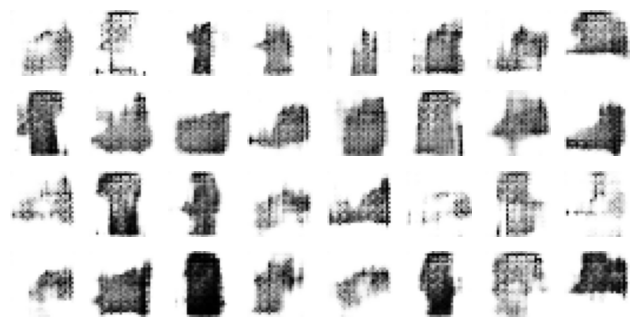

Epoch 5/10


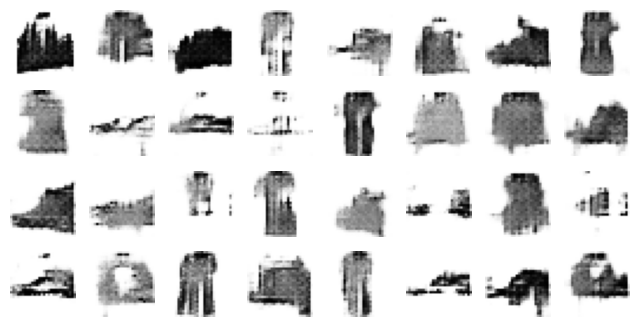

Epoch 6/10


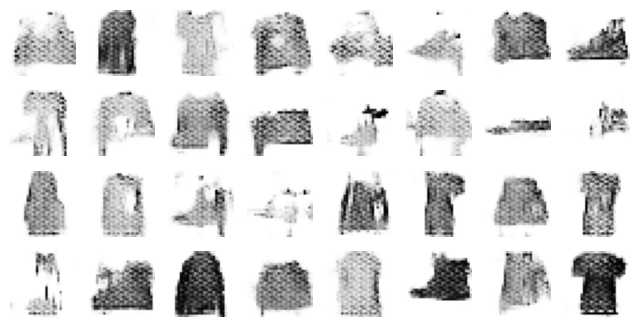

Epoch 7/10


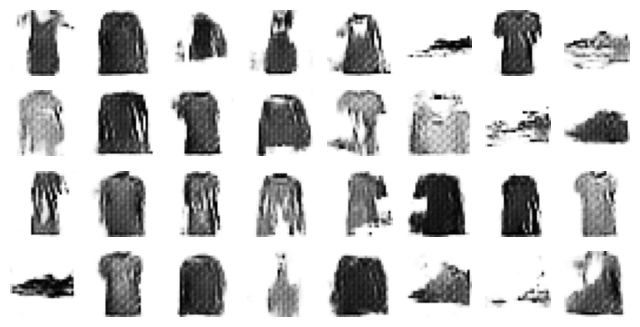

Epoch 8/10


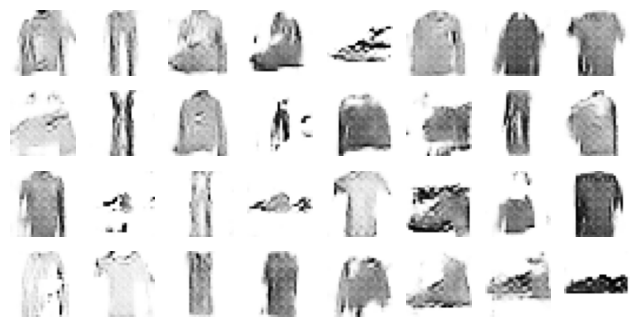

Epoch 9/10


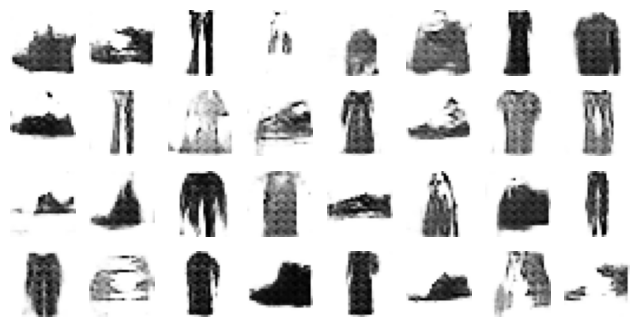

Epoch 10/10


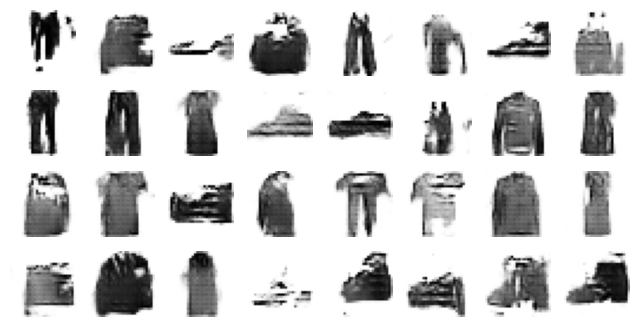

In [10]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

# 노이즈로 새로운 이미지 생성

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


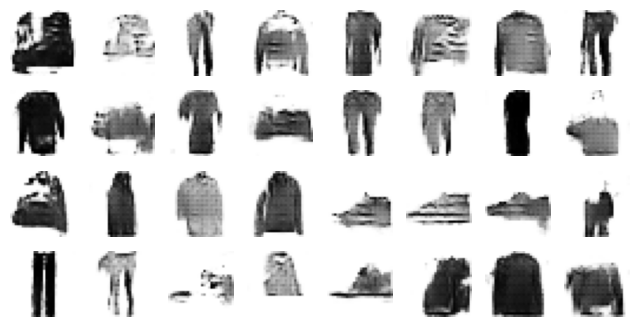

In [11]:
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8)